# Deep Learning

Here we will continue down the rabbit hole into LSTMs and other methods

In [1]:
from keras.layers import Input, Dense, Embedding, LSTM, Dense, Conv1D, MaxPooling1D, Dropout, Activation
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from sklearn.linear_model import SGDRegressor, Lasso, LinearRegression, ElasticNet, Ridge, LassoCV, RidgeCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR, SVR
import dlib
import json
import keras.callbacks
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse

Using TensorFlow backend.
/home/hexgnu/git/mlrw/env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/hexgnu/git/mlrw/env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
y = np.load('./ratings.npy')
doc_term_matrix = scipy.sparse.load_npz('./corpus.npz')

# The cool thing is we are taking 3100 ish inputs and mapping it onto 64.
# This is _very_ similar to PCA so keep that in mind. But the thing is it's incredibly tuneable.

input_img = Input(shape=(doc_term_matrix.shape[1],))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)

decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(doc_term_matrix.shape[1], activation='sigmoid')(decoded)

autoencoder = Model(input_img, decoded)

encoder = Model(input_img, encoded)

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [3]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, min_delta=0.0001)

X_train, X_test, y_train, y_test = train_test_split(doc_term_matrix, y, test_size=0.2, random_state=42)

autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, shuffle=True, validation_split=0.5, callbacks=[early_stop])

Train on 4000 samples, validate on 4000 samples
Epoch 1/50
4000/4000 [==============================] - 4s 947us/step - loss: 0.6926 - val_loss: 0.6920
Epoch 2/50
4000/4000 [==============================] - 3s 853us/step - loss: 0.6915 - val_loss: 0.6909
Epoch 3/50
4000/4000 [==============================] - 4s 914us/step - loss: 0.6904 - val_loss: 0.6898
Epoch 4/50
4000/4000 [==============================] - 3s 824us/step - loss: 0.6893 - val_loss: 0.6887
Epoch 5/50
4000/4000 [==============================] - 3s 685us/step - loss: 0.6881 - val_loss: 0.6875
Epoch 6/50
4000/4000 [==============================] - 4s 984us/step - loss: 0.6869 - val_loss: 0.6863
Epoch 7/50
4000/4000 [==============================] - 4s 1ms/step - loss: 0.6857 - val_loss: 0.6850
Epoch 8/50
4000/4000 [==============================] - 4s 1ms/step - loss: 0.6844 - val_loss: 0.6836
Epoch 9/50
4000/4000 [==============================] - 4s 942us/step - loss: 0.6829 - val_loss: 0.6820
Epoch 10/50
4000/400

In [4]:
autoencoder.evaluate(X_test, X_test)

2000/2000 [==============================] - 0s 174us/step


0.008125472601503134

This is really a good result. We are able to squeeze 3100ish dimensions into 32 and still effectively track what the data represents. Perhaps we could use this with our traditional ML regressions to get better results?

In [5]:
X_train_prime = encoder.predict(X_train)
X_test_prime = encoder.predict(X_test)

def try_all_regressors(X_train, y_train, X_test, y_test):
    regressors = [SGDRegressor(), 
                  Lasso(), 
                  LinearRegression(), 
                  ElasticNet(),
                  Ridge(),
                  SVR(kernel='linear'),
                  SVR(kernel='rbf')]

    def print_results(reg, y_test, y_pred):
        print('Regression {}'.format(reg))
        print('-' * 30)
        print(mean_absolute_error(y_test, y_pred))
        print('-' * 30)

    for reg in regressors:
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        print_results(reg, y_test, y_pred)

try_all_regressors(X_train_prime, y_train, X_test_prime, y_test)

/home/hexgnu/git/mlrw/env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Regression SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=None, penalty='l2',
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)
------------------------------
1.1003190430037002
------------------------------
Regression Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
------------------------------
1.0440755834579467
------------------------------
Regression LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
------------------------------
1.026175545692444
------------------------------
Regression ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,

.................................................................................
Best C: [0.16173926591414536] MAE: 0.9876517884974535


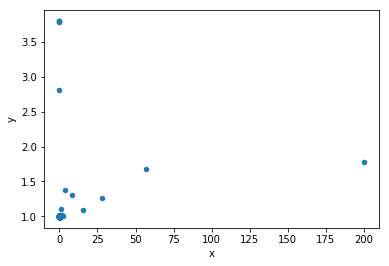

In [6]:
# This is "bleeding" edge stuff here 
# http://blog.dlib.net/2017/12/a-global-optimization-algorithm-worth.html

xes = []
yes = []

def svr_regressor(c):
    print('.', end='')
    reg = LinearSVR(C=c)
    reg.fit(X_train_prime, y_train)
    y_pred = reg.predict(X_test_prime)
    yes.append(mean_absolute_error(y_test, y_pred))
    xes.append(c)
    return mean_absolute_error(y_test, y_pred)

x, y = dlib.find_min_global(svr_regressor, [1e-15], [200], 80)
print('.')
print("Best C: {} MAE: {}".format(x, y))

svr_regressor = LinearSVR(C=x[0])
svr_regressor.fit(X_train_prime, y_train)

pd.DataFrame({'x': xes, 'y': yes}).plot.scatter(x='x', y='y')
plt.show()

In [7]:
# What would happen if we tried some other numbers like only 32 dense units in the middle. What about 2?

# Not really any better results huh?

Note that deep learning stuff doesn't always guarantee better results. Matter of fact when we added an autoencoder above it made it worse. Though notice that it levels the playing field between all of the algorithms. This is really a good thing!

We are still at +/- 1 star. This means that we can probably classify that it is either positive or negative reviews but nothing more. 

But let's think about this for a second...

Text is very sequential. When you say something what matters is what you just said + what you said a while back (context). 

A great model in the deep learning world is LSTMs (Long Short Term Memory) which is a version of a GRU (Gated Recurrent Unit).

They hold onto long term and short term inforamtion in a sequence. Let's try that?

In [8]:
# NOTE: You can make your own yelp.json on other text if you want :smile:

# import json
# texts = []
# binstars = []
# with open('./yelp.json') as jfile:
#     for obj in json.load(jfile):
#         if obj['stars'] != []:
#             texts.append(obj['review'][0].lower())
#             binstars.append(obj['stars'])

# balanced_texts = []
# balanced_labels = []
# limit = 2000 # Change this to grow/shrink the dataset
# neg_pos_counts = [0, 0, 0, 0, 0]
# for i in range(len(texts)):
#     polarity = binstars[i] - 1
#     if neg_pos_counts[polarity] < limit:
#         balanced_texts.append(texts[i])
#         balanced_labels.append(binstars[i])
#         neg_pos_counts[polarity] += 1

# np.save('./yelp-labels.npy', balanced_labels)
# np.save('./yelp-texts.npy', balanced_texts)

In [9]:
balanced_labels = np.load('./yelp-labels.npy')
balanced_texts = np.load('./yelp-texts.npy')

len(balanced_texts)

10000

In [10]:
tokenizer = Tokenizer(num_words=20000, lower=True)
tokenizer.fit_on_texts(balanced_texts)
sequences = tokenizer.texts_to_sequences(balanced_texts)
data = pad_sequences(sequences, maxlen=300)

X_train, X_test, y_train, y_test = train_test_split(data, balanced_labels, test_size=0.1, random_state=42)

y_train = np_utils.to_categorical(np.array(y_train)-1)
y_test = np_utils.to_categorical(np.array(y_test)-1)
tokenizer.word_index

{'the': 1,
 'and': 2,
 'i': 3,
 'to': 4,
 'a': 5,
 'was': 6,
 'is': 7,
 'of': 8,
 'it': 9,
 'for': 10,
 'in': 11,
 'this': 12,
 'food': 13,
 'but': 14,
 'my': 15,
 'we': 16,
 'that': 17,
 'place': 18,
 'not': 19,
 'with': 20,
 'they': 21,
 'good': 22,
 'you': 23,
 'had': 24,
 'have': 25,
 'so': 26,
 'on': 27,
 'here': 28,
 'were': 29,
 'are': 30,
 'at': 31,
 'be': 32,
 'service': 33,
 'as': 34,
 'like': 35,
 'there': 36,
 'very': 37,
 'just': 38,
 'time': 39,
 'their': 40,
 'all': 41,
 'if': 42,
 'out': 43,
 'me': 44,
 'go': 45,
 'get': 46,
 "it's": 47,
 'great': 48,
 'one': 49,
 'restaurant': 50,
 'when': 51,
 'really': 52,
 'our': 53,
 'chicken': 54,
 'from': 55,
 'soup': 56,
 'been': 57,
 'would': 58,
 'or': 59,
 'about': 60,
 'up': 61,
 'order': 62,
 'back': 63,
 'wait': 64,
 'only': 65,
 'ordered': 66,
 'dumplings': 67,
 'no': 68,
 "don't": 69,
 'too': 70,
 "i've": 71,
 'pork': 72,
 'what': 73,
 'some': 74,
 'got': 75,
 '\xa0the': 76,
 'because': 77,
 'more': 78,
 '\xa0i': 79,
 'p

In [11]:
lstm = Sequential()
lstm.add(Embedding(20000, 128, input_length=300))
lstm.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
lstm.add(Dense(5, activation='sigmoid', kernel_initializer='normal'))
lstm.compile(optimizer=Adam(lr=0.002), loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_acc', patience=2, min_delta=0.0001)

lstm.fit(X_train, y_train, validation_split=0.2, epochs=20, callbacks=[early_stop])

Train on 7200 samples, validate on 1800 samples
Epoch 1/20
7200/7200 [==============================] - 138s 19ms/step - loss: 0.5057 - acc: 0.7988 - val_loss: 0.4839 - val_acc: 0.8000
Epoch 2/20
7200/7200 [==============================] - 104s 14ms/step - loss: 0.4437 - acc: 0.8043 - val_loss: 0.4354 - val_acc: 0.8024
Epoch 3/20
7200/7200 [==============================] - 135s 19ms/step - loss: 0.3549 - acc: 0.8354 - val_loss: 0.4266 - val_acc: 0.8032
Epoch 4/20
7200/7200 [==============================] - 120s 17ms/step - loss: 0.2837 - acc: 0.8756 - val_loss: 0.4455 - val_acc: 0.7922
Epoch 5/20
7200/7200 [==============================] - 117s 16ms/step - loss: 0.2227 - acc: 0.9072 - val_loss: 0.4972 - val_acc: 0.7830


In [13]:
lstm.evaluate(X_test, y_test)

1000/1000 [==============================] - 3s 3ms/step


[0.4958817367553711, 0.7823999938964844]

In [14]:
model = Sequential()
model.add(Embedding(20000, 128, input_length=300, trainable=False))
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(128))
model.add(Dense(5, activation='sigmoid'))
model.compile(optimizer=Adam(lr=0.002), loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_acc', patience=2, min_delta=0.0001)

model.fit(X_train, y_train, validation_split=0.2, epochs=50, callbacks=[early_stop])

Train on 7200 samples, validate on 1800 samples
Epoch 1/50
7200/7200 [==============================] - 31s 4ms/step - loss: 0.5050 - acc: 0.7988 - val_loss: 0.4973 - val_acc: 0.8000
Epoch 2/50
7200/7200 [==============================] - 39s 5ms/step - loss: 0.4845 - acc: 0.8002 - val_loss: 0.4753 - val_acc: 0.8010
Epoch 3/50
7200/7200 [==============================] - 38s 5ms/step - loss: 0.4587 - acc: 0.8032 - val_loss: 0.4538 - val_acc: 0.8059
Epoch 4/50
7200/7200 [==============================] - 40s 6ms/step - loss: 0.4310 - acc: 0.8079 - val_loss: 0.4499 - val_acc: 0.8057
Epoch 5/50
7200/7200 [==============================] - 35s 5ms/step - loss: 0.4117 - acc: 0.8140 - val_loss: 0.4369 - val_acc: 0.8080
Epoch 6/50
7200/7200 [==============================] - 43s 6ms/step - loss: 0.3812 - acc: 0.8247 - val_loss: 0.4355 - val_acc: 0.8080
Epoch 7/50
7200/7200 [==============================] - 33s 5ms/step - loss: 0.3597 - acc: 0.8342 - val_loss: 0.4463 - val_acc: 0.7959


In [16]:
model.evaluate(X_test, y_test)

1000/1000 [==============================] - 1s 996us/step


[0.4457242588996887, 0.7984000015258789]

In [23]:
indexes = []
for i in range(5):
    indexes.append(list(balanced_labels).index(i + 1))

pd.DataFrame({'text': balanced_texts[indexes], 'y_true': balanced_labels[indexes]})

,text,y_true
0,my mom wanted pho and since she has pneumonia ...,1
1,whoever said this place has the best bun bo hu...,2
2,wasn't a huge fan of their pho nor do i prefer...,3
3,this place isn't the best vietnamese food i've...,4
4,phenomenal service and great food. the waitres...,5


In [18]:
# Confidence in this case is something I made up.
# If the value for each variable is 0.2 then it is a uniform distribution of possibility
# The higher the better obviously

df = pd.DataFrame({'text': balanced_texts, 'y_true': balanced_labels, 
              'y_pred': [a.argmax() + 1 for a in model.predict(data)],
              'confidence': [(a.max() - 0.2)/0.8 for a in model.predict(data)]})

# If confidence is 0.2 then it's zero

In [19]:
mean_absolute_error(df['y_true'], df['y_pred'])

0.5115

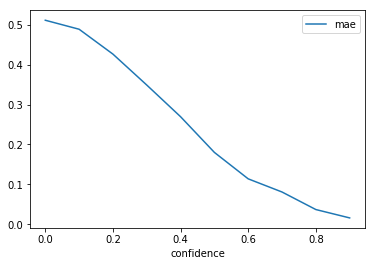

In [20]:
mae = pd.DataFrame({'confidence': np.array(range(10))*0.1,
              'support': [df[df['confidence'] > i * 0.1].shape[0] for i in range(10)]})

errors = []

for i in range(10):
    z = i * 0.1
    g = df[df['confidence'] > z]
    errors.append(mean_absolute_error(g['y_true'], g['y_pred']))

mae['mae'] = errors

mae.plot(x='confidence', y='mae')

In [21]:
# We now have some good results at X% accuracy. Which isn't bad!

# How can we deploy this?

# A lot of this will be covered in next week about how to explain results

# Deploying machine learning models

Machine learning models basically break down to a set of weights and configuration for the most part.

Deploying is usually a simple problem of pickling / serializing the weights and loading them for future use.

In [22]:
# A simple deployment already available easily
import spacy

nlp = spacy.load('en')

# ^^ This is a way of deploying a model. This object 'nlp' handles all kinds of neat stuff. It's fairly easy to do in python as well

/home/hexgnu/git/mlrw/env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/hexgnu/git/mlrw/env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


OSError: [E050] Can't find model 'en'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.

In [24]:
# Inside of python we can use pickle
import pickle

# save the tokenizer and model
# 692K on disk. easy peasy
with open("keras_tokenizer.pickle", "wb") as f:
    pickle.dump(tokenizer, f)

# 12M on disk. Not too much
model.save("yelp_review_model.hdf5")

In [25]:
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
import pickle
 
# load the tokenizer and the model
with open("keras_tokenizer.pickle", "rb") as f:
    tokenizer = pickle.load(f)

model = load_model("yelp_review_model.hdf5")
 
# replace with the data you want to classify
newtexts = ["This place sucked!!!",
            "I love the bun bo hue here, give me more please!! The best!",
            "meh it was alright",
            "The lychee was rotten"]
 
# note that we shouldn't call "fit" on the tokenizer again
sequences = tokenizer.texts_to_sequences(newtexts)
data = pad_sequences(sequences, maxlen=300)
 
# get predictions for each of your new texts
model.predict(data)

array([[0.34725222, 0.25262633, 0.08028258, 0.15704961, 0.18187436],
       [0.01549916, 0.02508737, 0.16652931, 0.44731304, 0.41649395],
       [0.20617895, 0.32570526, 0.1981845 , 0.22788769, 0.12332564],
       [0.28298303, 0.2591452 , 0.16170146, 0.18845776, 0.13608661]],
      dtype=float32)

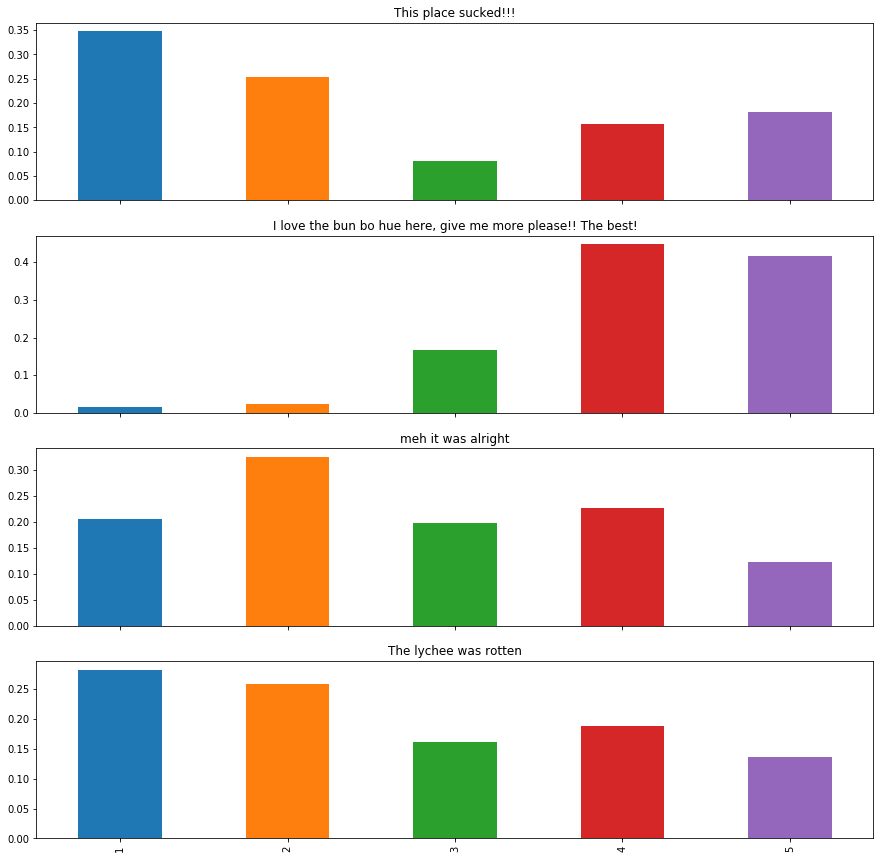

In [26]:
# model.predict(data)

fix, axes = plt.subplots(nrows=4, sharex=True, figsize=(15,15))

for i, r in enumerate(model.predict(data)):
    ax = axes[i]
    ax.set_title(newtexts[i])
    pd.Series(r, index=range(1,6)).plot.bar(ax=ax)

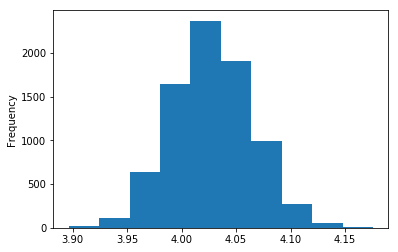

In [27]:
# To deploy sklearn modules is similar

from sklearn.externals import joblib

joblib.dump(svr_regressor, "svr_regressor.pickle")
regressor = joblib.load('svr_regressor.pickle')

# get predictions for each of your new texts
# NOTE: I forgot to save the vectorizer in my original code...
# You can do that fairly easy with textacy
pd.Series(regressor.predict(X_train_prime)).plot.hist()